In [ ]:
from model import SI4RDVr

In [20]:
vf = {
    'infection' : list(map(lambda x: x/24, [0, 0.05, 0.3, 0.2])),
    'promotion' : list(map(lambda x: x/24, [0.1, 0.2, 0.5, 0.1])),
    'death' : list(map(lambda x: x/24, [0, 0.0001, 0.003, 0])),
    'recoveryL' : 0.051 /24,
    'vaccinG' : 0.001/24,
    'vaccinL' : 0.0009 /24,
    'recoveryI' : 0.998,
    'vaccinI' : 0.978
}
ins = {
    'startH' : 0,
    'infected' : [5],
    'population' : [10**6]
}

In [21]:
mod = SI4RDVr(regions=1, virusFactors=vf, initialSettings=ins)
for i in range(24*365*2): mod.updateH()

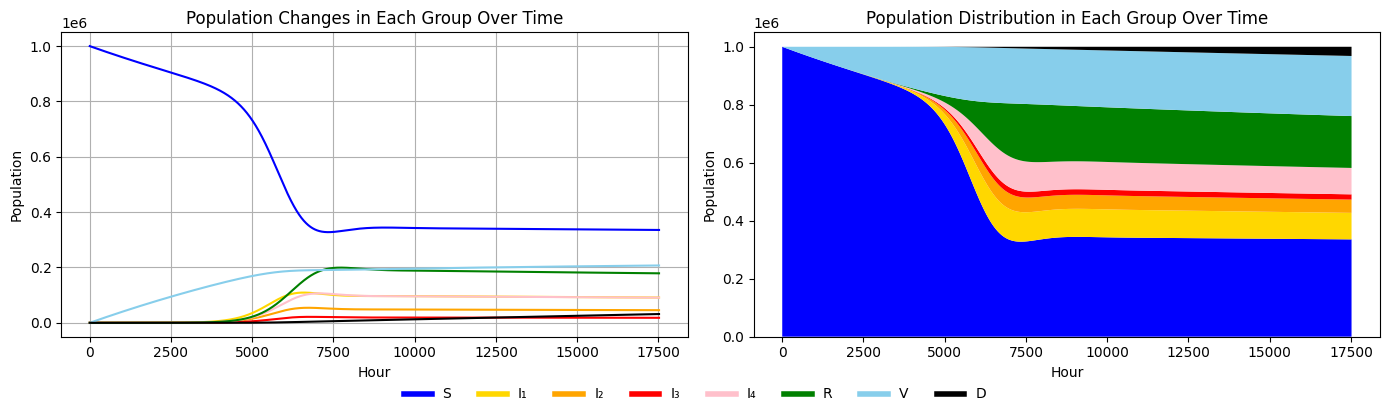

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

dts = np.squeeze(np.array(mod.logList), axis=1).T

labels = ['S','I₁','I₂','I₃','I₄','R','V','D']
colors = ['blue','gold','orange','red','pink','green','skyblue','black']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4), gridspec_kw={'width_ratios':[1, 1]})

for i, label in enumerate(labels):
    ax1.plot(dts[i], label=label, color=colors[i])
ax1.set_title("Population Changes in Each Group Over Time")
ax1.set_xlabel("Hour")
ax1.set_ylabel("Population")
ax1.grid(True)

x = np.arange(dts.shape[1])
ax2.stackplot(x, dts, labels=labels, colors=colors)

ax2.set_title("Population Distribution in Each Group Over Time")
ax2.set_xlabel("Hour")
ax2.set_ylabel("Population")
ax2.grid(False)

handles = [plt.Line2D([0], [0], color=colors[i], lw=4) for i in range(len(labels))]
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05),
           ncol=len(labels), fontsize=10, frameon=False)

plt.tight_layout()
plt.show()


In [ ]:
from model import SI4RDVr
vf = {
    'infection' : list(map(lambda x: x/24, [0, 0.05, 0.3, 0.2])),
    'promotion' : list(map(lambda x: x/24, [0.1, 0.2, 0.5, 0.1])),
    'death' : list(map(lambda x: x/24, [0, 0.0001, 0.003, 0])),
    'recoveryL' : 0.051 /24,
    'vaccinG' : 0.001/24,
    'vaccinL' : 0.0009 /24,
    'recoveryI' : 0.998,
    'vaccinI' : 0.978
}
ins = {
    'startH' : 0,
    'infected' : [5000]+[0]*24,
    'population' : list(pd.read_csv('popByDistrict', encoding='utf-8')['pop']),
}
mod = SI4RDVr(regions=25, movM=np.load('movementM.npy'), virusFactors=vf, initialSettings=ins)
for i in range(24*365*2): mod.updateH()


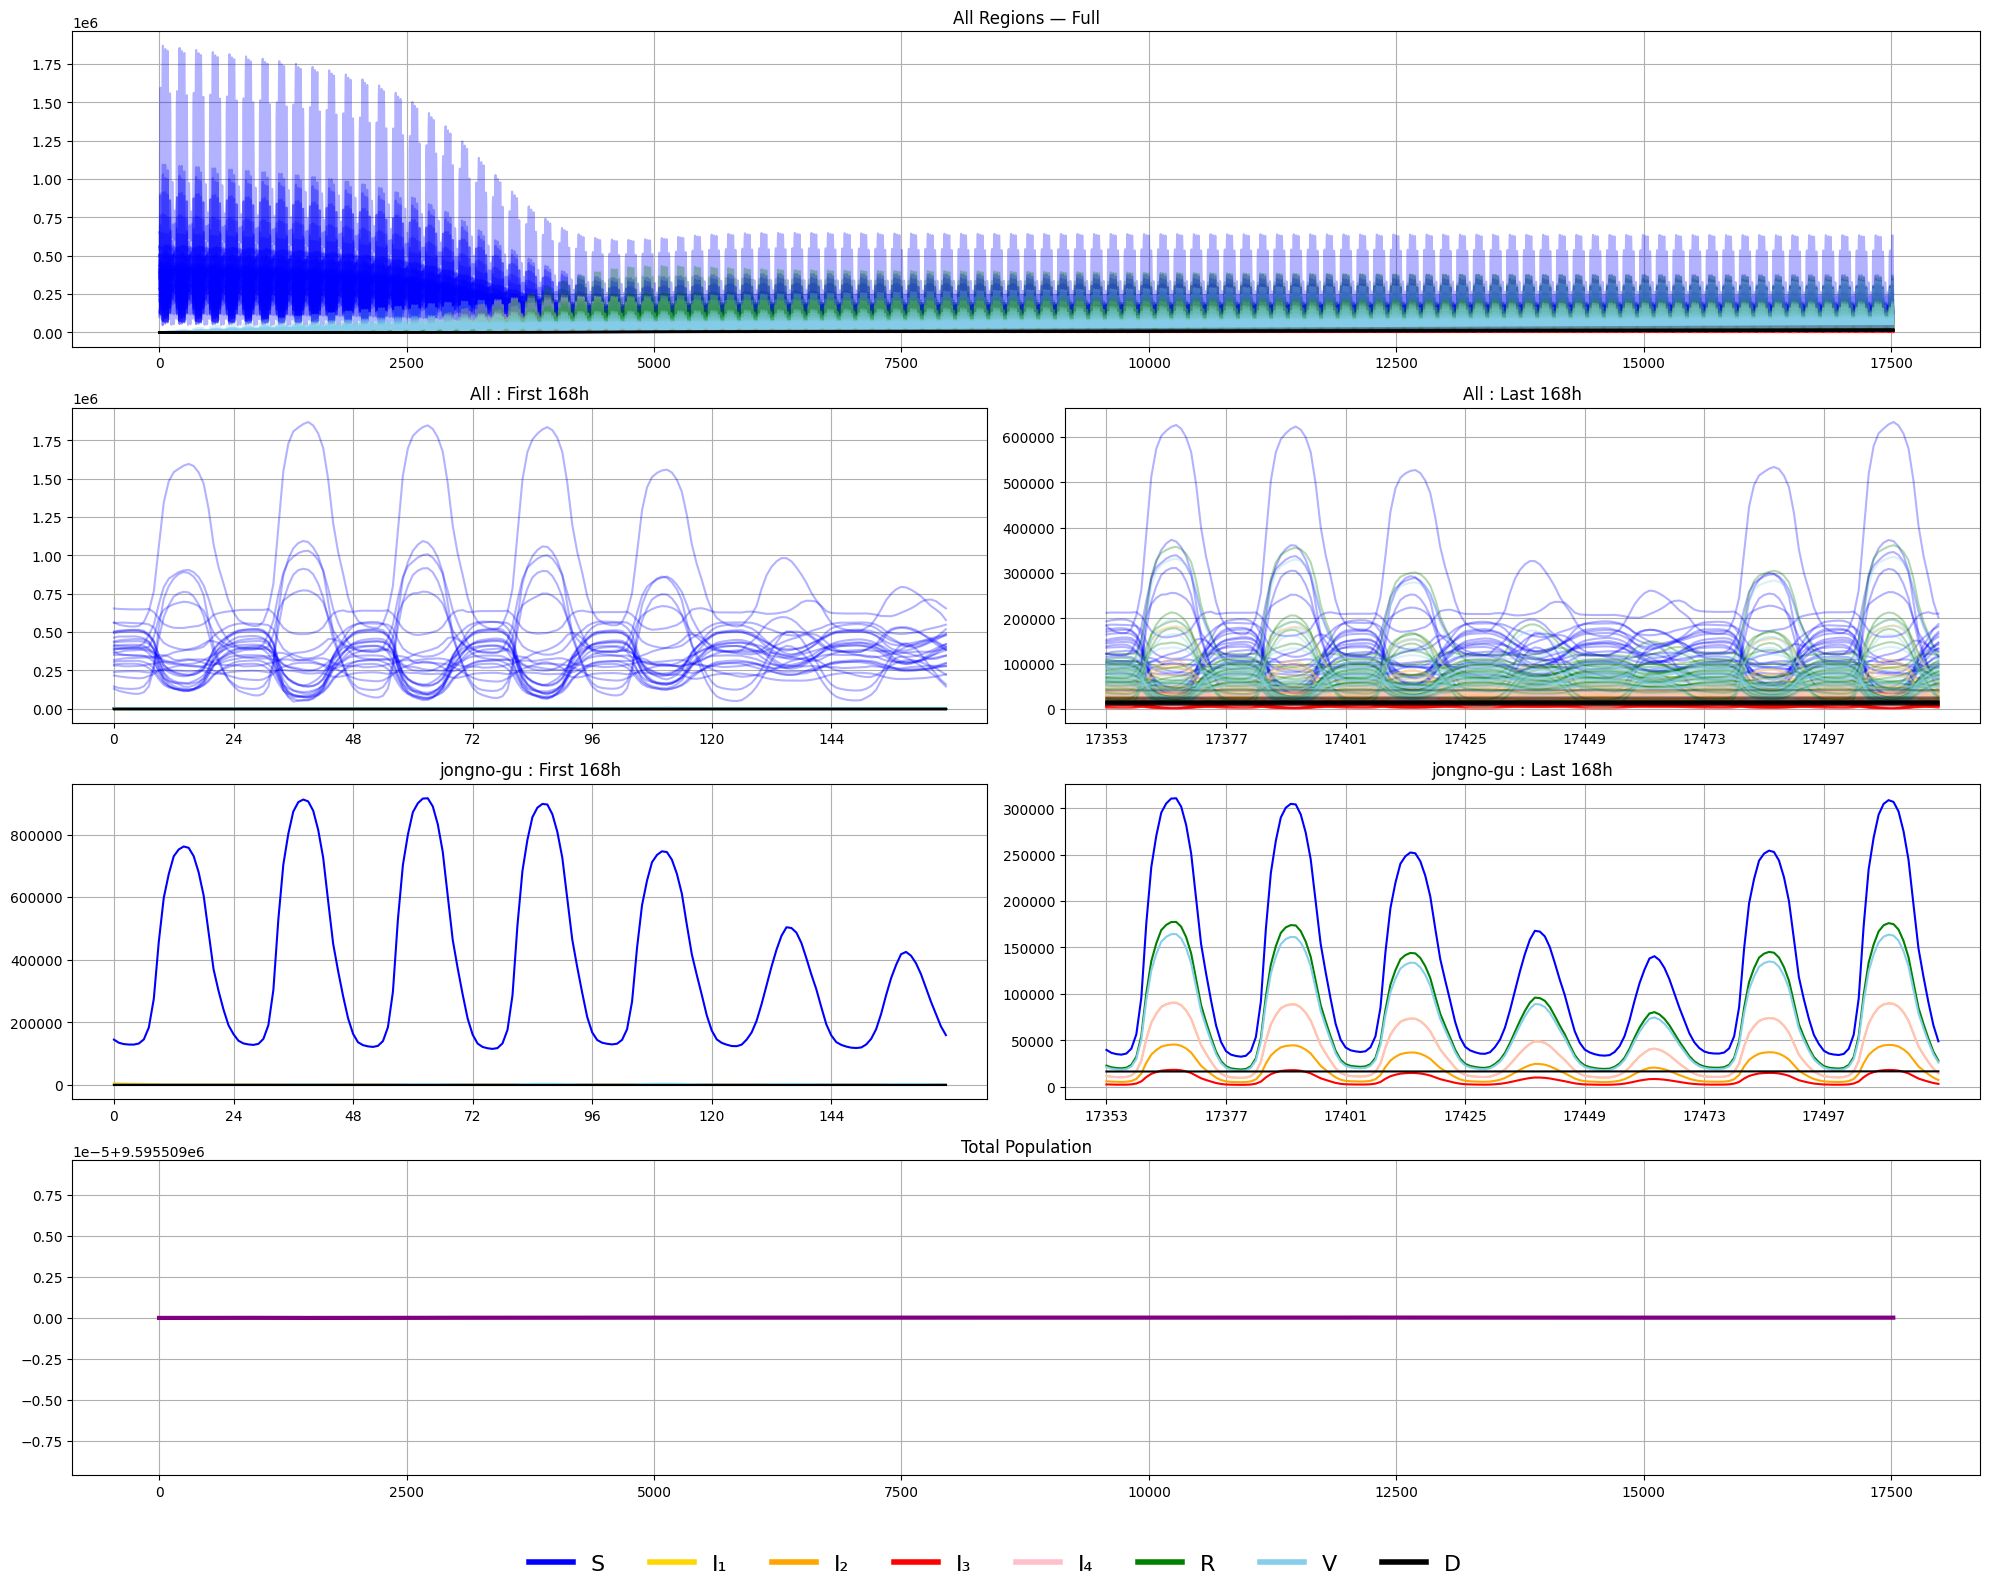

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

arr = np.array(mod.logList)
R, G = arr.shape[1], arr.shape[2]
labels = ['S','I₁','I₂','I₃','I₄','R','V','D']
colors = ['blue','gold','orange','red','pink','green','skyblue','black']

T = arr.shape[0]
x = np.arange(T, dtype=int)
tot = arr.sum((1,2))

fig = plt.figure(figsize=(20,16))
tick = np.arange(0, T, 24)

ax = plt.subplot2grid((4,2),(0,0),colspan=2)
for g in range(G):
    for r in range(R):
        ax.plot(x, arr[:,r,g], color=colors[g], alpha=0.3)
ax.set_title("All Regions — Full")
ax.grid(True)

s0,e0 = 0,168
s1,e1 = T-168,T
x0,x1 = np.arange(s0,e0, dtype=int), np.arange(s1,e1, dtype=int)

ax21 = plt.subplot2grid((4,2),(1,0))
ax22 = plt.subplot2grid((4,2),(1,1))
ax31 = plt.subplot2grid((4,2),(2,0))
ax32 = plt.subplot2grid((4,2),(2,1))

for g in range(G):
    for r in range(R):
        ax21.plot(x0, arr[s0:e0,r,g], color=colors[g], alpha=0.3)
        ax22.plot(x1, arr[s1:e1,r,g], color=colors[g], alpha=0.3)
    ax31.plot(x0, arr[s0:e0,0,g], color=colors[g])
    ax32.plot(x1, arr[s1:e1,0,g], color=colors[g])
    
for a, x_range in zip([ax21, ax22, ax31, ax32], [x0, x1, x0, x1]):
    ticks = x_range[::24]
    a.set_xticks(ticks)
    a.set_xticklabels(ticks)
    a.grid(True)

ax21.set_title("All : First 168h")
ax22.set_title("All : Last 168h")
ax31.set_title("jongno-gu : First 168h")
ax32.set_title("jongno-gu : Last 168h")

axb = plt.subplot2grid((4,2),(3,0),colspan=2)
axb.plot(x, tot, color='purple', lw=3)
axb.set_title("Total Population")
axb.grid(True)

fig.legend([plt.Line2D([0],[0],color=colors[i],lw=4) for i in range(G)],
           labels, loc='lower center', bbox_to_anchor=(0.5,-0.03),
           ncol=len(labels), frameon=False, fontsize=16)

plt.tight_layout(rect=[0,0.02,1,0.97])
plt.show()


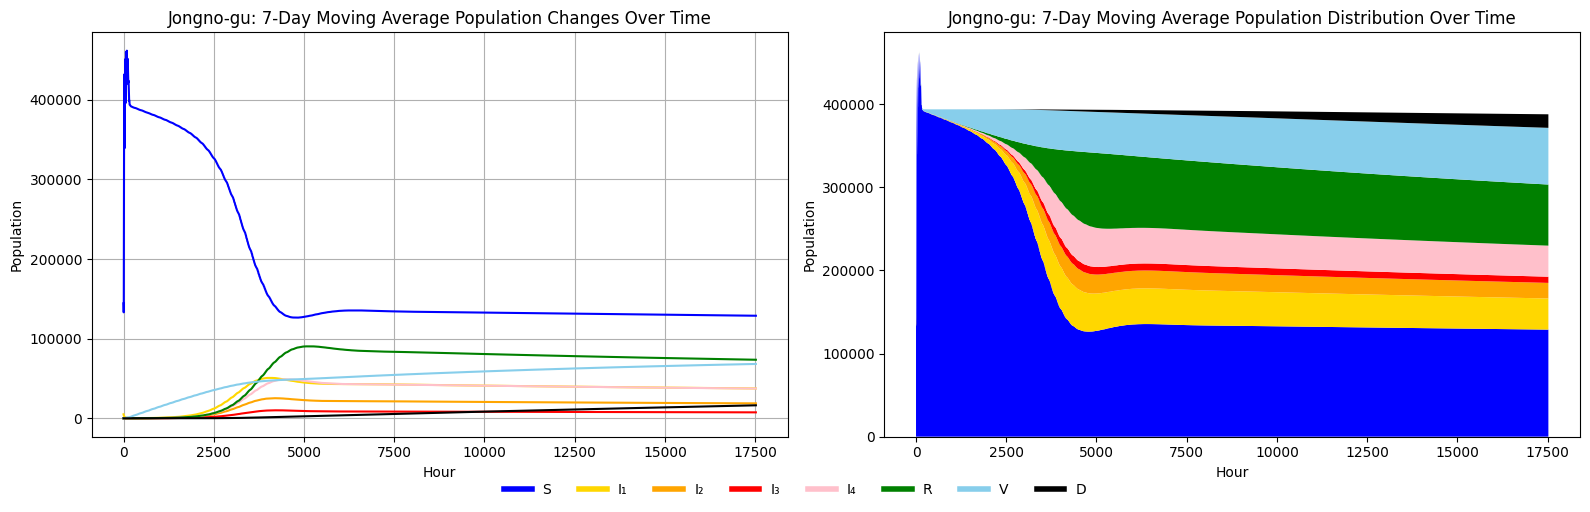

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

arr = np.array(mod.logList)
jongno = arr[:, 0, :]  # 종로구 데이터, shape (시간, 8)

labels = ['S','I₁','I₂','I₃','I₄','R','V','D']
colors = ['blue','gold','orange','red','pink','green','skyblue','black']

# DataFrame으로 변환
dts = pd.DataFrame(jongno, columns=labels)

# 7일 이동평균: 윈도우 = 7일 * 24시간 = 168
dts_ma = dts.rolling(window=168, min_periods=1).mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), gridspec_kw={'width_ratios':[1,1]})

# 선그래프
for i, label in enumerate(labels):
    ax1.plot(dts_ma[label], label=label, color=colors[i])
ax1.set_title("Jongno-gu: 7-Day Moving Average Population Changes Over Time")
ax1.set_xlabel("Hour")
ax1.set_ylabel("Population")
ax1.grid(True)

# 스택그래프
x = np.arange(len(dts_ma))
ax2.stackplot(x, [dts_ma[label] for label in labels], labels=labels, colors=colors)
ax2.set_title("Jongno-gu: 7-Day Moving Average Population Distribution Over Time")
ax2.set_xlabel("Hour")
ax2.set_ylabel("Population")
ax2.grid(False)

# 범례
handles = [plt.Line2D([0], [0], color=colors[i], lw=4) for i in range(len(labels))]
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05),
           ncol=len(labels), fontsize=10, frameon=False)

plt.tight_layout()
plt.show()
